### HW 7 Assignment 1

In [1]:
##REMINDER TO ADD README

In [2]:
import urllib
import pandas as pd
import geopandas
import os
%matplotlib inline
from matplotlib import *
import sys
import pylab as pl
import requests
import json
import numpy as np
import io
from fiona.crs import from_epsg 
import shapely
import geopandas as gpd
from datetime import datetime
from datetime import timedelta
from censusAPI import myAPI

In [3]:
###Worked with Mei Guan @MeiGuan and Ross MacWhinney @RossMacW

In [4]:
#create the env variable since previous doesn't work
os.environ["PUIDATA"] = "%s/PUI2018/PUIdata"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/sjf374/PUI2018/PUIdata


## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

In [5]:
def PUMA():
    print ("Downloading")
    if not os.path.isfile(os.getenv("PUIDATA") + "/puma.zip"):
        print ("no zip in puidata")
        if not os.path.isfile("puma.zip"):
            print ("no zip in current folder")
            urllib.request.urlretrieve('https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile', "puma.zip")                  

    os.system("mv puma.zip " + os.getenv("PUIDATA"))
    print ("moving zipped file")
    
    ### unzip the csv 
    os.system("unzip "+ os.getenv("PUIDATA") + "/puma.zip -d " + os.getenv("PUIDATA"))
    print ("unzipped file")

    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/puma.zip"):
        print ("WARNING!!! something is wrong: the %s file is not there!" % (x))

    else:
        print ("file in place, you can continue")

In [6]:
PUMA()

Downloading
moving zipped file
unzipped file
file in place, you can continue


In [7]:
#consider the fact that the string changes everytime....

In [8]:
# shapefiles = ['dbf', 'prj', 'shp', 'shx']

In [9]:
# shapedict = {}

In [10]:
# for x in shapefiles:
#     shapedict[x] = geopandas.GeoDataFrame.from_file(os.getenv("PUIDATA")\
#                                                     + '/geo_export_79f4e48b-26c3-4d2b-821a-dde8ae134ac6.' + x)

In [11]:
#mei wrote this and I adjusted for my use
for file in (os.listdir(os.getenv("PUIDATA"))):
    path = (os.getenv("PUIDATA") + '/')
    if file.endswith(".dbf"):
        os.rename(path + file, path + 'NYC_PUMAS' + '.dbf')
    if file.endswith(".prj"):
        os.rename(path + file, path + 'NYC_PUMAS' + '.prj')
    if file.endswith(".shp"):
        os.rename(path + file, path + 'NYC_PUMAS' + '.shp')
    if file.endswith(".shx"):
        os.rename(path + file, path + 'NYC_PUMAS' + '.shx')


In [12]:
shape = geopandas.GeoDataFrame.from_file(os.getenv("PUIDATA")\
                        + '/NYC_PUMAS.shp')



In [13]:
shape.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [14]:
shape.crs

{'init': 'epsg:4326'}

## 1.2  plot the PUMA NYC regions

Text(0.5,1,'New York Shape File')

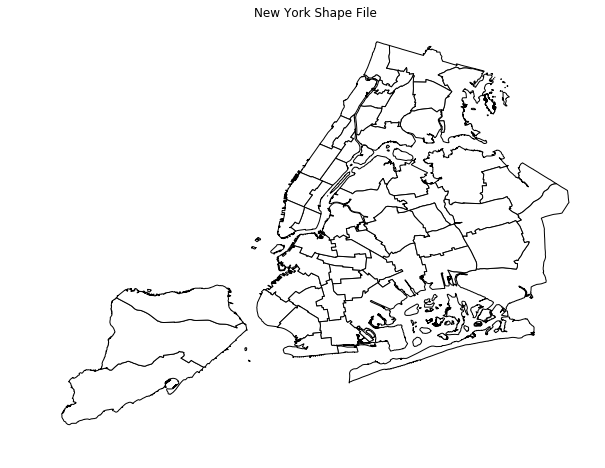

In [15]:
shape.plot(color="white", edgecolor="black", figsize=(10,10)).axis('off')
pl.title('New York Shape File')

#### Figure 1: Plotting the shape file of new york. Each row is a different polygon that can be identified with a white outline. 

## 2.1 Get data with American Fact Finder (AFF) API: 

In [16]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [17]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

In [18]:
aff1y

{'variables': {'B15002H_013E': {'attributes': 'B15002H_013M,B15002H_013EA',
   'concept': 'SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER (WHITE ALONE, NOT HISPANIC OR LATINO)',
   'group': 'B15002H',
   'label': 'Estimate!!Total!!Female!!9th to 12th grade, no diploma',
   'limit': 0,
   'predicateType': 'int'},
  'B17001I_030E': {'attributes': 'B17001I_030M,B17001I_030EA',
   'concept': 'POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGE (HISPANIC OR LATINO)',
   'group': 'B17001I',
   'label': 'Estimate!!Total!!Income in the past 12 months below poverty level!!Female!!75 years and over',
   'limit': 0,
   'predicateType': 'int'},
  'C27012_008E': {'attributes': 'C27012_008M,C27012_008EA',
   'concept': 'HEALTH INSURANCE COVERAGE STATUS AND TYPE BY WORK EXPERIENCE BY AGE',
   'group': 'C27012',
   'label': 'Estimate!!Total!!Worked full-time, year-round!!18 to 64 years!!With health insurance coverage!!With Medicaid/means-tested public coverage',
   'limit': 0,
   'p

In [19]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [20]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [21]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

## 2.2 generate a feature for the percentage of households with broadband access

In [22]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

In [23]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))


pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [24]:
pumaPP['public use microdata area'].nunique()

145

In [25]:
mergeddf = pd.merge(pumaPP, pumaBB, how='outer', on='public use microdata area')

In [26]:
mergeddf.head()

,B28002_001E,NAME_x,state_x,public use microdata area,Unnamed: 4_x,B28002_004E,NAME_y,state_y,Unnamed: 4_y
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN,32607,"St. Lawrence County PUMA, New York",36,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN,41210,"Warren & Washington Counties PUMA, New York",36,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,47786,Oneida County (Central)--Greater Utica & Rome ...,36,NaN


In [27]:
#percentage of households constructed
mergeddf['pcBB'] = (mergeddf['B28002_004E'] / mergeddf['B28002_001E'])*100

In [28]:
mergeddf.head()

,B28002_001E,NAME_x,state_x,public use microdata area,Unnamed: 4_x,B28002_004E,NAME_y,state_y,Unnamed: 4_y,pcBB
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN,32607,"St. Lawrence County PUMA, New York",36,NaN,80.552879
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,NaN,75.733321
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN,41210,"Warren & Washington Counties PUMA, New York",36,NaN,79.842678
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,NaN,81.433409
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,47786,Oneida County (Central)--Greater Utica & Rome ...,36,NaN,78.150656


## 2.4 check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [29]:
os.system("unzip "+ os.getenv("PUIDATA") + \
          "/ACS_16_1YR_GCT2801.ST50.zip -d " + \
          os.getenv("PUIDATA"))


256

In [30]:
#read in the csv from the unzipped file downloaded manually from the internet
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [31]:
#fix column names
bbpc = bbpc.rename(columns=bbpc.iloc[0]).loc[1:]

In [32]:
bbpc.head()

,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


In [33]:
#check the type before trying to join
bbpc.dtypes

Target Geo Id2     object
Percent            object
Margin of Error    object
dtype: object

In [34]:
#change type to integer
bbpc['Target Geo Id2'] = bbpc['Target Geo Id2'].astype(int)

In [35]:
#change the geoid so it is relatable to the api created dataframe
bbpc['gid'] = bbpc['Target Geo Id2'].astype(int) - 3600000
bbpc.head()

,Target Geo Id2,Percent,Margin of Error,gid
1,1,74.7,0.5,-3599999
2,100100,70.9,2.5,-3499900
3,100200,80.5,2.7,-3499800
4,100301,87.0,2.8,-3499699
5,100302,81.9,2.9,-3499698


In [36]:
#merge the api dataframe and the downloaded one to check the differences 
#in the calcluated vs the downloaded version
diff_ = mergeddf.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "Percent"]]

diff_['Percent'] = diff_['Percent'].astype(float)
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["Percent"])

diff_.describe()

,pcBB,Percent,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


# 3 Plot a choropleth of NYC broadband access 
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [37]:
#check the dataframes again before merging them 

In [38]:
shape.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [39]:
bbpc.head()

,Target Geo Id2,Percent,Margin of Error,gid
1,1,74.7,0.5,-3599999
2,100100,70.9,2.5,-3499900
3,100200,80.5,2.7,-3499800
4,100301,87.0,2.8,-3499699
5,100302,81.9,2.9,-3499698


In [40]:
shape.dtypes

puma           object
shape_area    float64
shape_leng    float64
geometry       object
dtype: object

In [41]:
#does not work without making puma into an int

In [42]:
shape['puma'] = shape['puma'].astype(int)

In [43]:
#merge them together
pumashp = pd.merge(left=shape, right=bbpc, left_on='puma', right_on='gid')

In [44]:
pumashp.head()

,puma,shape_area,shape_leng,geometry,Target Geo Id2,Percent,Margin of Error,gid
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,3603701,84.3,2.6,3701
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",3603702,68.3,3.7,3702
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,3603703,82.8,3.2,3703
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",3603704,72.6,3.6,3704
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,3604015,78.8,2.9,4015


In [45]:
#check those types again
pumashp.dtypes

puma                 int64
shape_area         float64
shape_leng         float64
geometry            object
Target Geo Id2       int64
Percent             object
Margin of Error     object
gid                  int64
dtype: object

In [46]:
#lets make the percent a number or else it will register as categorical

In [47]:
pumashp['Percent'] = pumashp['Percent'].astype('float')

Text(0.5,1,'Percent Households with Broadband Access')

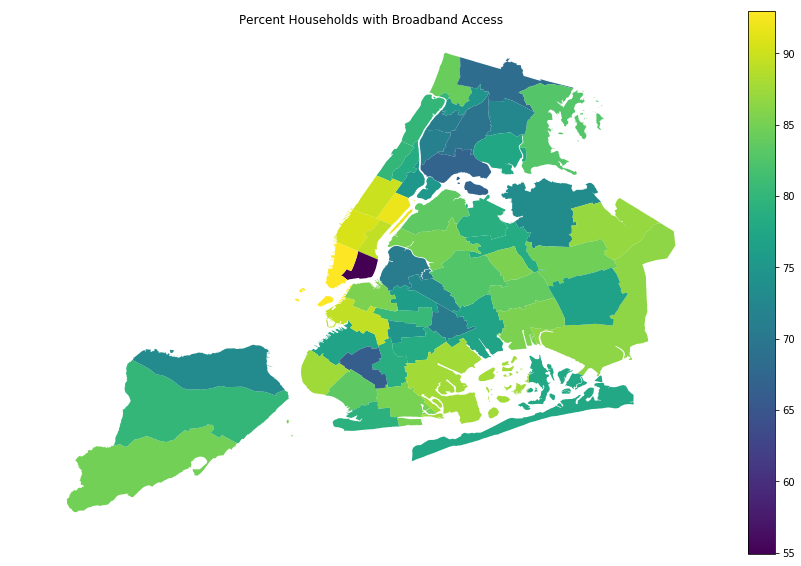

In [48]:
pumashp.plot(column='Percent', figsize=(15,10), legend=True).axis('off')
pl.title('Percent Households with Broadband Access')

#### Figure 2: Access to broadband varies quite a bit within new york city. This graph shows that those in the lower east manhattan seem to have the lowest percent of households with broadband

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

In [49]:
def getlinkNYC():
    '''
    gets link NYC data locations in csv form
    '''
    print ("Downloading")
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/linkNYClocations.csv"):
        if os.path.isfile('linkNYClocations.csv'):
            # if in the current dir just move it
            os.system("mv linkNYClocations.csv " + os.getenv("PUIDATA"))
        #otherwise download file
        else:
            os.system("curl -O https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv > linkNYClocations.csv")
            ###  To move it I use the os.system() functions to run bash commands with arguments
            os.system("mv  linkNYClocations.csv" + os.getenv("PUIDATA"))
    
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/linkNYClocations.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [50]:
getlinkNYC()

Downloading
file in place, you can continue


In [51]:
linkNYCdf = pd.read_csv(os.getenv("PUIDATA") + "/linkNYClocations.csv")

In [52]:
linkNYCdf.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [53]:
#fix the unnamed column
linkNYCdf = linkNYCdf.iloc[0:,1:]

In [54]:
linkNYCdf.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [55]:
linkNYCdf.shape

(1414, 4)

In [56]:
type(linkNYCdf)

pandas.core.frame.DataFrame

## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame _linkNYC_ and set native coordinates  frame to lat/lon as you did in the lab

In [57]:
# combine lat and lon to one column
linkNYCdf['lonlat']=list(zip(linkNYCdf['longitude'],linkNYCdf['latitude']))
# Create Point Geometry for based on lonlat column
linkNYCdf['geometry']=linkNYCdf[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYCdf.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [58]:
#make the time in the correct format
linkNYCdf['date_link_'] = pd.to_datetime(linkNYCdf['date_link_'])

In [59]:
#find time elapsed for graphing
linkNYCdf['timepassed'] = linkNYCdf['date_link_'].apply(lambda x: (datetime.today() - x).days)

In [60]:
#make the dataframe into a geodf
linkNYCgdf = gpd.GeoDataFrame(linkNYCdf)

In [61]:
#apply the correct Coordinate Reference System
pumashp.crs = from_epsg(4326)
linkNYCgdf.crs = from_epsg(4326)
linkNYCgdf = linkNYCgdf.to_crs(pumashp.crs)

In [62]:
#this allows the two to be mapped on top of eachother and have the same system

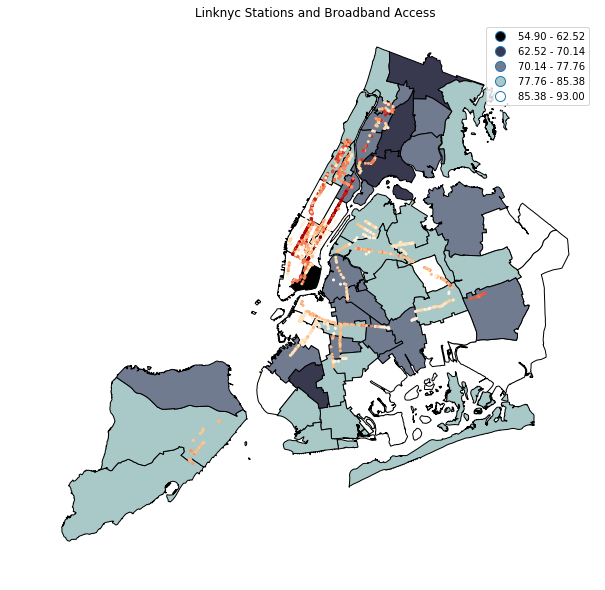

In [63]:
#plot the dataframes
fig, ax = pl.subplots(figsize=(10,10))

pumashp.plot(ax=ax, column='Percent', figsize=(30), legend=True, \
             edgecolor="black", k = 5, scheme = 'Equal_interval', \
             cmap='bone').axis('off')
linkNYCgdf.plot(ax=ax, column='timepassed', k = 5, figsize=(30), marker='o', markersize=4, cmap='OrRd')
pl.title('Linknyc Stations and Broadband Access')

pl.show()

### Figure 3: Though the darker colors on the map show which areas have less broadband access, there doesn't seem to be many linkNYC stations in those areas (the varying colors of red dots). This is most likely where they are needed most. The figure also shows how long a link station has been in place and it is clear that manhattan recieved many of these before  other areas of the city. 

# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

##### had quite a bit of difficulty with this section
    While trying to work on it the api said I had requested too many times, so I needed to get a key
    Luckily my classmates that I worked with, seemed to have a better understanding about how to manipulate these datasets
    


In [88]:
keyPop = 'B00001_001E'

url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

In [89]:
pumashp.head()

,puma,shape_area,shape_leng,geometry,Target Geo Id2,Percent,Margin of Error,gid
index_right,,,,,,,,
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",3603701,84.3,2.6,3701
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796877 256069.2766112776,...",3603702,68.3,3.7,3702
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142089319...,3603703,82.8,3.2,3703
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972045382,...",3603704,72.6,3.6,3704
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",3604015,78.8,2.9,4015


In [90]:
pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [91]:
pumashpPop = pumashp.merge(pumaPop, left_on = 'puma', right_on = 'public use microdata area')

In [92]:
linkNYCgdf.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry,timepassed
index_left,,,,,,,
0,4001,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (1000196.411360609 194918.1045344363),483
1,4001,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (1000284.976955119 194872.4991186759),483
2,4001,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (1000265.48686938 195013.900946364),483
3,4001,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (1000076.658138533 196154.157733508),547
4,4001,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (997155.0239397929 204558.4761382252),575


## 5.2 find the number of station per 100 people per PUMA
**Important** you can do this with an sjoin(). But sjoin() should not be used with lat/lon coordinates cause they are **not "flat coordinates"**. Since spattial joins are done in cartesian geometry the only coordinate systems suitable to spatial joins are flat coordinate plane systems, which in the NYC area is 2263. So before you proceed to the sjoin you have to convert both pumashp and linkNYC to 2263 (for example with GeoDataFrame method .to_crs(epsg=...) )
​
​
(A note: You can also do this by hand by asking for each point if it is in any of the regions, for example in a for loop. But that is escruciatingly slow, unless you get smart about your requests (for example for a given PUMA not asking if the coordinates of a point are very different from the center of a PUMA). With the new version of geopandas this is not needed, cause the sjoin is fast, but with the older versions this was sometimes better) )

In [93]:
## This snippet is from Chris Prince
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False


a=[]
#setup a progressbar
if hasWidgets:
    pb = widgets.FloatProgress(min=0, max=1, description="Creating pts:")
    display(pb)
step = 0.05
updatestep = 0

# check for each linkNYC to see what puma they are belong to

for i in range(len(linkNYCgdf)):
    a.append(pumashp[pumashp.geometry.intersects(linkNYCgdf.iloc[i].geometry)]\
             .puma.values[0])
    progress = (i+1)/len(linkNYCgdf)
    curstep = progress//step
    if hasWidgets:
        pb.value = progress
    elif updatestep!=curstep:
        # should use /r, but this is currently broken in jupyterlab, 
        # see https://github.com/jupyterlab/jupyterlab/issues/5326
        print ('{:.0f}%'.format(progress*100), end=" ")
        updatestep=curstep
linkNYCgdf['link_site'] = a
if hasWidgets: pb.description = "Done!"
else: print ("100%")

5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 100%


In [ ]:
#check and change the crs

In [94]:
pumashp.crs

{'init': 'epsg:2263', 'no_defs': True}

In [95]:
linkNYCgdf.crs == pumashp.crs

True

In [96]:
linkNYCgdf = linkNYCgdf.to_crs(epsg=2263)
pumashp = pumashp.to_crs(epsg=2263)

create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

In [97]:
pumashp.head()

,puma,shape_area,shape_leng,geometry,Target Geo Id2,Percent,Margin of Error,gid
index_right,,,,,,,,
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841917932,...",3603701,84.3,2.6,3701
1,3702,1.889860e+08,106050.002302,"POLYGON ((1027331.841796878 256069.2766112172,...",3603702,68.3,3.7,3702
2,3703,2.670137e+08,304071.257466,(POLYGON ((1042822.450195312 243439.8142088761...,3603703,82.8,3.2,3703
3,3704,1.062129e+08,47970.901277,"POLYGON ((1026308.769592285 256767.6972044777,...",3603704,72.6,3.6,3704
4,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312517 171933.9880369949,...",3604015,78.8,2.9,4015


In [98]:
linkNYCgdf.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry,timepassed
index_left,,,,,,,
0,4001,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (1000196.411360609 194918.1045343759),483
1,4001,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (1000284.976955119 194872.4991186248),483
2,4001,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (1000265.48686938 195013.9009463128),483
3,4001,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (1000076.658138533 196154.1577334476),547
4,4001,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (997155.0239397929 204558.4761381648),575


In [ ]:
#join the two dataframes together and find the count of each --- rename the columns

In [100]:
linkpp = gpd.sjoin(linkNYCgdf, pumashp).groupby('puma').count().reset_index()[['puma', 'link_site']]
linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [105]:
# merge that dataframe with the population dataframe on the puma 

In [101]:
pumashplc = linkpp.merge(pumashpPop, left_on = 'puma', right_on = 'puma', how = 'outer')
pumashplc.head()

,puma,link_site,shape_area,shape_leng,geometry,Target Geo Id2,Percent,Margin of Error,gid,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3701.0,1.0,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",3603701,84.3,2.6,3701,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3705.0,1.0,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",3603705,69.4,3.2,3705,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN
2,3706.0,20.0,4.388687e+07,51799.404183,"POLYGON ((1015266.210021974 257032.2927855904,...",3603706,74.7,3.6,3706,1274,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN
3,3707.0,29.0,4.228113e+07,37347.925798,"POLYGON ((1012642.970825195 252164.6224364594,...",3603707,70.6,3.5,3707,1548,NYC-Bronx Community District 5--Morris Heights...,36,3707,NaN
4,3708.0,19.0,5.589695e+07,34852.437966,"POLYGON ((1009024.520385744 246341.7731933084,...",3603708,71.3,3.9,3708,1462,"NYC-Bronx Community District 4--Concourse, Hig...",36,3708,NaN


In [103]:
#create calculation for percent per 100 inhabitants
pumashplc['linkNYCp100p'] = (pumashplc['link_site']/pumashplc['B00001_001E'])*100
pumashplc.head()

,puma,link_site,shape_area,shape_leng,geometry,Target Geo Id2,Percent,Margin of Error,gid,B00001_001E,NAME,state,public use microdata area,Unnamed: 4,linkNYCp100p
0,3701.0,1.0,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",3603701,84.3,2.6,3701,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,0.065920
1,3705.0,1.0,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",3603705,69.4,3.2,3705,2011,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,0.049727
2,3706.0,20.0,4.388687e+07,51799.404183,"POLYGON ((1015266.210021974 257032.2927855904,...",3603706,74.7,3.6,3706,1274,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,NaN,1.569859
3,3707.0,29.0,4.228113e+07,37347.925798,"POLYGON ((1012642.970825195 252164.6224364594,...",3603707,70.6,3.5,3707,1548,NYC-Bronx Community District 5--Morris Heights...,36,3707,NaN,1.873385
4,3708.0,19.0,5.589695e+07,34852.437966,"POLYGON ((1009024.520385744 246341.7731933084,...",3603708,71.3,3.9,3708,1462,"NYC-Bronx Community District 4--Concourse, Hig...",36,3708,NaN,1.299590


In [104]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

In [ ]:
pumashplc

In [113]:
pumashplc.dtypes

puma                         float64
link_site                    float64
shape_area                   float64
shape_leng                   float64
geometry                      object
Target Geo Id2                 int64
Percent                      float64
Margin of Error               object
gid                            int64
B00001_001E                    int64
NAME                          object
state                          int64
public use microdata area      int64
Unnamed: 4                   float64
linkNYCp100p                 float64
dtype: object

In [117]:
#make the dataframe into a geodf
pumashplc = gpd.GeoDataFrame(pumashplc)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


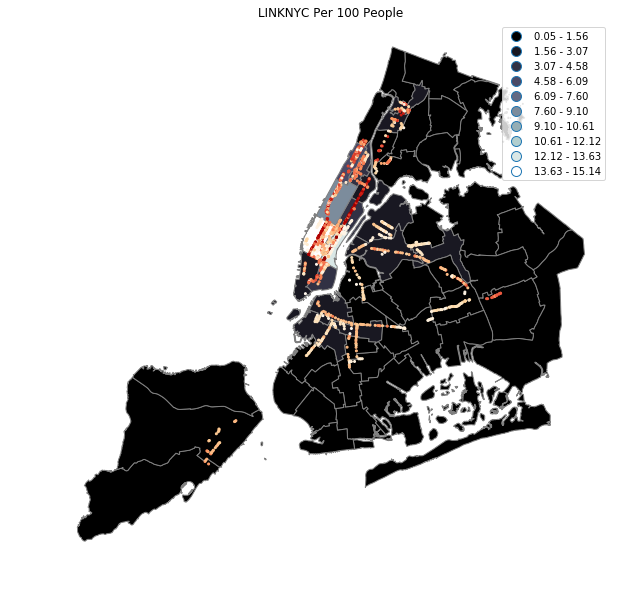

In [124]:
#plot the dataframes
fig, ax = pl.subplots(figsize=(10,10))

pumashplc.plot(ax=ax, column='linkNYCp100p', figsize=(30), legend=True, \
             edgecolor="gray", k = 10, scheme = 'Equal_interval', \
             cmap='bone').axis('off')
linkNYCgdf.plot(ax=ax, column='timepassed', k = 5, figsize=(30), marker='o', markersize=4, cmap='OrRd')
pl.title('LINKNYC Per 100 People')

pl.show()

### Figure 4: Map of the ratio of people in each puma to the amount of linknyc stations

###### manhattan clearly has an advantage, though it can be argued that the linkNYCs are for tourists and would not be counted in these ratis